# Introduction

This notebook attempts to improve the score from `roger_exploration_scale_pos_weight.ipynb` of 0.69450 (model `10906675_xgb_es_spw.joblib`, henceforth the baseline model) by using `CalibratedClassifierCV`. The baseline model has already used early stopping and 

## Summary
* the validation AUC of the [`CalibratedClassifierCV`](#CalibratedClassifierCV) is the same as the one from the baseline model, 0.724, however, there are more predictions in the positive class; the f1-score
* the [results of test AUC](#Results-of-test-AUC) did not improve; 0.69390. 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

from src.data.make_dataset import load_sets, save_sets, save_predictions
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie, create_feature_importance_df, plot_feature_importances, plot_calibration_curve


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [4]:
competition = os.environ['COMPETITION']

# Set up directories

In [5]:
project_dir = Path.cwd().parent.parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [6]:
X_train, X_val, y_train, y_val, X_test = load_sets(interim_data_dir)
X_train_lim, X_val_lim, y_train_lim, y_val_lim, X_test_lim = load_sets(interim_data_dir, suffix='top_8_features')
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

# Baseline

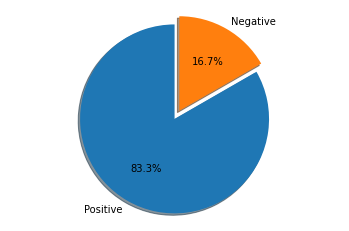

In [7]:
plot_pie(y_train)

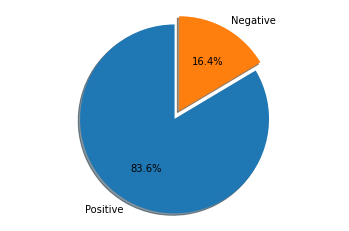

In [8]:
plot_pie(y_val)

# Load best model

The best model so far is `randomised_xgb.joblib` with a test AUC of 0.69051.

In [9]:
model_name = '10906675_xgb_es_spw.joblib'
base_model = load(models_dir / model_name)

## Baseline Score

The best validation AUC score from the previous attempt is 0.696.

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  53 1015]
 [  16 5316]]
Accuracy:  0.83890625
AUC:  0.7719218252596858
              precision    recall  f1-score   support

           0       0.77      0.05      0.09      1068
           1       0.84      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.80      0.52      0.50      6400
weighted avg       0.83      0.84      0.78      6400



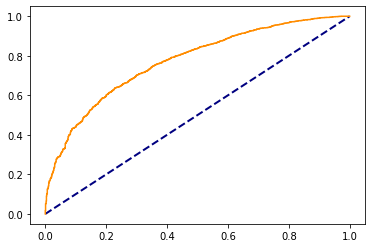

In [24]:
classification_reports(base_model, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   5  258]
 [   6 1331]]
Accuracy:  0.835
AUC:  0.6962824665629594
              precision    recall  f1-score   support

           0       0.45      0.02      0.04       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.83      1600
   macro avg       0.65      0.51      0.47      1600
weighted avg       0.77      0.83      0.77      1600



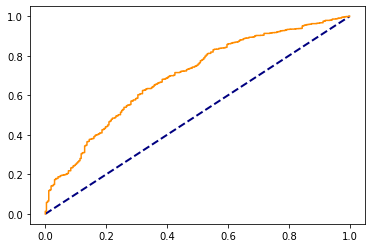

In [25]:
classification_reports(base_model, X_val, y_val)

# Calibration curves

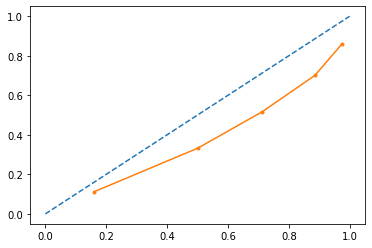

In [14]:
probs = base_model.predict_proba(X_train)[:, 1]
plot_calibration_curve(y_train, probs, normalize=True)

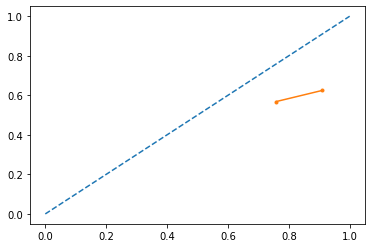

In [15]:
probs = base_model.predict_proba(X_val)[:, 1]
plot_calibration_curve(y_val, probs)

In [12]:
pd.Series(probs).describe()

count    1600.000000
mean        0.597051
std         0.035191
min         0.476298
25%         0.575717
50%         0.600746
75%         0.623643
max         0.675532
dtype: float64

It turns out that the probabilities are concentrated only in the range 0.48 and 0.68.

# `CalibratedClassifierCV`

In [16]:
cal_cv = CalibratedClassifierCV(base_estimator=base_model,
                                cv='prefit')

cal_cv.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scaler',
                                                       StandardScaler()),
                                                      ('pca',
                                                       PCA(n_components=8)),
                                                      ('classifier',
                                                       XGBClassifier(base_score=0.5,
                                                                     booster='gbtree',
                                                                     colsample_bylevel=1,
                                                                     colsample_bynode=1,
                                                                     colsample_bytree=0.590700201239684,
                                                                     eval_metric='logloss',
                                                                     gamma=0,
                           

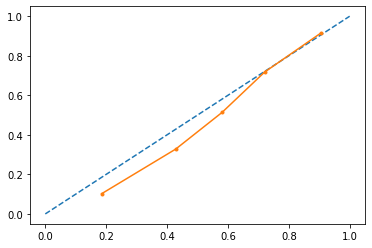

In [19]:
probs = cal_cv.predict_proba(X_train)[:, 1]
plot_calibration_curve(y_train, probs, normalize=True)

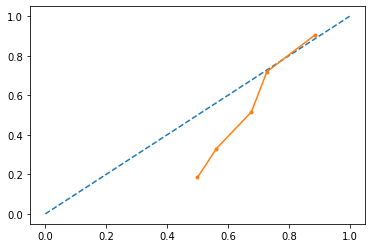

In [20]:
probs = cal_cv.predict_proba(X_val)[:, 1]
plot_calibration_curve(y_val, probs)

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[ 180  888]
 [ 121 5211]]
Accuracy:  0.84234375
AUC:  0.7719217374568362
              precision    recall  f1-score   support

           0       0.60      0.17      0.26      1068
           1       0.85      0.98      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.73      0.57      0.59      6400
weighted avg       0.81      0.84      0.80      6400



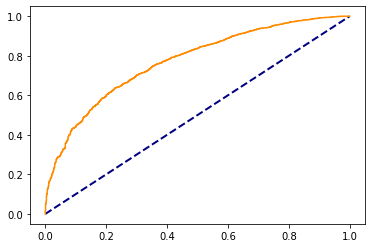

In [21]:
classification_reports(cal_cv, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  26  237]
 [  45 1292]]
Accuracy:  0.82375
AUC:  0.6962824665629594
              precision    recall  f1-score   support

           0       0.37      0.10      0.16       263
           1       0.84      0.97      0.90      1337

    accuracy                           0.82      1600
   macro avg       0.61      0.53      0.53      1600
weighted avg       0.77      0.82      0.78      1600



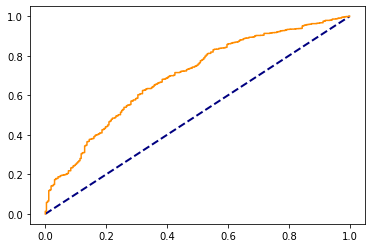

In [22]:
classification_reports(cal_cv, X_val, y_val)

The validation AUC is the same that in `roger_exploration_scale_pos_weight.ipynb`, at 0.6962824665629594, however, the calibrated version has a better combination of f1-scores:

| Class | Not Calibrated | Calibrated |   |   |
|-------|----------------|------------|---|---|
| 0     | 0.04           | 0.16       |   |   |
| 1     | 0.91           | 0.90       |   |   |
|       |                |            |   |   |

## Save model

In [26]:
model_name = '10906675_xgb_es_spw_cal.joblib'
model_path = models_dir / model_name
model_path

WindowsPath('D:/Projects/assignment_1/models/10906675_xgb_es_spw_cal.joblib')

In [27]:
dump(cal_cv, model_path)

['D:\\Projects\\assignment_1\\models\\10906675_xgb_es_spw_cal.joblib']

# Prediction on test set

In [28]:
probs = cal_cv.predict_proba(X_test)[:, 1]

In [29]:
probs

array([0.79704678, 0.86965179, 0.94957238, ..., 0.70043892, 0.96994317,
       0.80929905])

In [30]:
path = processed_data_dir / f'probs_{model_name}.csv'
save_predictions(probs, 'TARGET_5Yrs', test_id, path)

## Submit predictions

In [31]:
api.competition_submit(file_name=path,
                       message=model_name,
                       competition=competition,
                       quiet=False)

100%|█████████████████████████████████████████████████████████████████████████████| 91.3k/91.3k [00:05<00:00, 18.1kB/s]


Successfully submitted to [UTS AdvDSI] NBA Career Prediction

# Results of test AUC

The test AUC is also 0.69390.